In [95]:
from dotenv import load_dotenv
import os
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

In [96]:
load_dotenv()

cleaned_data_path = os.getenv("CLEANED_DATA_PATH")

# Checks to see that the CSV is properly loaded and ready to go into a dataframe

if cleaned_data_path is None:
    print("Error: CSV not found in .env file.")
else:
    print(f"CSV loaded successfully!")

CSV loaded successfully!


In [97]:
df = pd.read_parquet(cleaned_data_path)
print(df.info())
# Date, flight number, and destination airport aren't necessary for analysis, but I'm choosing to keep them for the sake of reproducible validation checks.

<class 'pandas.core.frame.DataFrame'>
Index: 78266 entries, 0 to 78270
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date                            78266 non-null  datetime64[ns]
 1   flight_number                   78266 non-null  string        
 2   tail_number                     78266 non-null  string        
 3   destination_airport             78266 non-null  string        
 4   scheduled_departure_time        78266 non-null  datetime64[ns]
 5   actual_departure_time           78266 non-null  datetime64[ns]
 6   departure_delay                 78266 non-null  int64         
 7   wheels_off_time                 78266 non-null  datetime64[ns]
 8   taxi_out_time                   78266 non-null  Int64         
 9   delay_carrier                   78266 non-null  Int64         
 10  delay_weather                   78266 non-null  Int64         
 11  delay_n

## Feature Engineering

Flight Identification\
[x] departure_id (int): A unique integer identifier for each departure, beginning at 1

Temporal & Volume\
[x] hour_of_day (int): Extracted hour from scheduled_departure_time\
[x] day_of_week (int): Extracted from date using 0 = Monday through 6 = Sunday\
[x] peak_hour_flag (int): 1 if hour's flight volume > mean + 1 stdev, else 0

Delay Analysis
[x] delay_flag (int): 1 if departure_delay > 15, else 0\
[x] delay_proportion_carrier (float): Proportion of delay caused by carrier compared to length of all delays\
[x] delay_proportion_late_aircraft (float): Proportion of delay caused by late aircraft compared to length of all delays\
[x] mean_departure_delay_by_hour (float): Aggregate delays by hour_of_day w/ mean window function\
[x] total_reasoned_delay (int): Total delay caused by known reasons

Aircraft Scheduling

[x] previous_actual_departure_time (datetime): actual_departure_time of the previous flight for the same tail_number\
[x] buffer_time (float): Time difference (in minutes) between scheduled_departure_time and previous_actual_departure_time for the same tail_number

Ground Operations\
[x] taxi_out_category (string): Categories based on percentiles of taxi_out_time

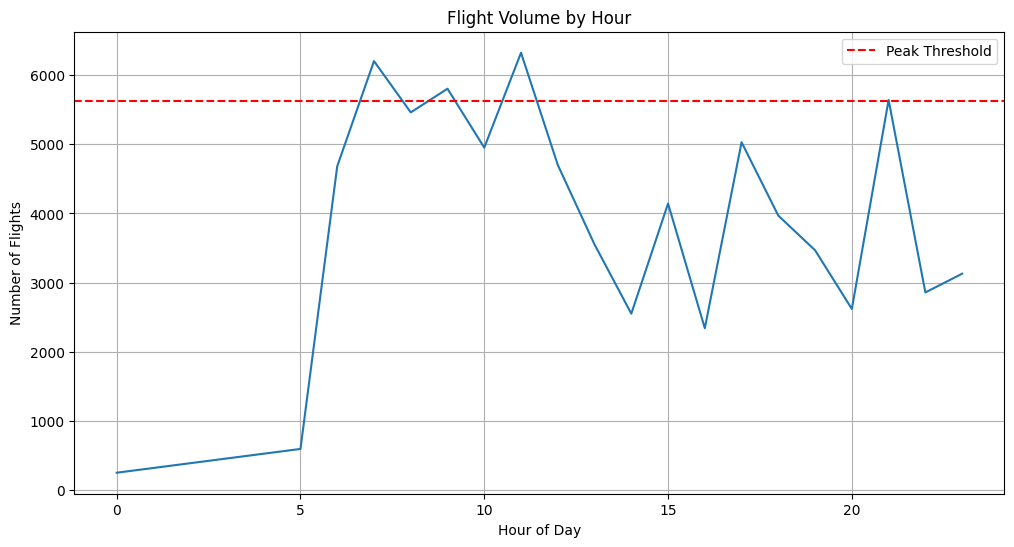

In [98]:
# Make an explicit index column 'trip_id' in case SQL/others need a primary key
df.insert(0, 'departure_id', range(1, len(df)+1)) # Starting at 1 for easy indexing in SQL/others
df.set_index('departure_id', inplace=True, drop=False)

# Delay flag
df['delay_flag'] = np.where(df['departure_delay'] > 15, 1, 0)

# Delay proportion carrier
df['delay_proportion_carrier'] = df['delay_carrier'] / df['departure_delay']
df['delay_proportion_carrier'] = df['delay_proportion_carrier'].replace(-0.0, 0.0) # Cleaning up display of 0's

# Delay proportion late aircraft
df['delay_proportion_late_aircraft'] = df['delay_late_aircraft_arrival'] / df['departure_delay']
df['delay_proportion_late_aircraft'] = df['delay_proportion_late_aircraft'].replace(-0.0, 0.0) # Cleaning up display of 0's

# Extract hour (int)
df['hour_of_day'] = df['scheduled_departure_time'].dt.hour

# Using window functions to calculate mean departure delay by hour
df['mean_departure_delay_by_hour'] = df.groupby('hour_of_day')['departure_delay'].transform('mean')

# Add delays due to reasons
df['total_reasoned_delay'] = df['delay_carrier'] + df['delay_weather'] + df['delay_national_aviation_system'] + df['delay_security'] + df['delay_late_aircraft_arrival']

# Day of week as integer
df['day_of_week'] = df['date'].dt.dayofweek

# Determine peak hour, then make flag for it
hourly_volume = (
    df['scheduled_departure_time'].dt.hour
    .value_counts()
    .sort_index()
    .reset_index()
    .rename(columns={'scheduled_departure_time': 'flight_count'})
)

hourly_volume.columns = ['hour', 'flight_count']

mean_volume = hourly_volume['flight_count'].mean()
std_volume = hourly_volume['flight_count'].std()

peak_threshold = mean_volume + std_volume

df['peak_hour_flag'] = (
    df.groupby(df['scheduled_departure_time'].dt.hour)['scheduled_departure_time']
    .transform('count')
    > peak_threshold
).astype(int)

# Plotting this new peak hour feature to ensure threshold makes sense
plt.figure(figsize=(12, 6))
plt.plot(hourly_volume['hour'], hourly_volume['flight_count'])
plt.axhline(y=peak_threshold, color='r', linestyle='--', label='Peak Threshold')
plt.title('Flight Volume by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Flights')
plt.legend()
plt.grid(True)

In [99]:
# Previous actual departure time
df = df.sort_values(['tail_number', 'scheduled_departure_time'])

df['previous_actual_departure_time'] = (
    df.groupby('tail_number')['actual_departure_time']
    .shift(1)
)

# Buffer time
df['buffer_time'] = (
    (df['scheduled_departure_time'] - df['previous_actual_departure_time'])
    .dt.total_seconds() / 60  # Convert to minutes
)

# Taxi out time categorization
labels = ['very short', 'short', 'long', 'very long']

df['taxi_out_category'] = pd.qcut(
    df['taxi_out_time'],
    q=4,
    labels=labels
)

In [100]:
# Print the boundaries for each taxi out category
category_ranges = pd.qcut(df['taxi_out_time'], q=4, retbins=True)
boundaries = category_ranges[1]

for i, label in enumerate(labels):
    if i < len(boundaries) - 1:
        print(f"{label}: {boundaries[i]:.1f} to {boundaries[i+1]:.1f} minutes")

very short: 0.0 to 16.0 minutes
short: 16.0 to 20.0 minutes
long: 20.0 to 25.0 minutes
very long: 25.0 to 168.0 minutes


In [101]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 78266 entries, 503 to 78080
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   departure_id                    78266 non-null  int64         
 1   date                            78266 non-null  datetime64[ns]
 2   flight_number                   78266 non-null  string        
 3   tail_number                     78266 non-null  string        
 4   destination_airport             78266 non-null  string        
 5   scheduled_departure_time        78266 non-null  datetime64[ns]
 6   actual_departure_time           78266 non-null  datetime64[ns]
 7   departure_delay                 78266 non-null  int64         
 8   wheels_off_time                 78266 non-null  datetime64[ns]
 9   taxi_out_time                   78266 non-null  Int64         
 10  delay_carrier                   78266 non-null  Int64         
 11  delay

In [102]:
# Rearranging columns by purpose to make analysis easier. "E" denotes an engineered feature
column_order = [
    # Identification & Validation
    'departure_id',          # E
    'flight_number',
    'tail_number',
    'destination_airport',
    'date',
    
    # Core Time Features
    'scheduled_departure_time',
    'actual_departure_time',
    'wheels_off_time',
    'hour_of_day',          # E
    'day_of_week',          # E
    'peak_hour_flag',       # E
    
    # Aircraft Sequence
    'previous_actual_departure_time',  # E
    'buffer_time',          # E
    
    # Delay Measurements
    'departure_delay',
    'delay_flag',           # E
    'mean_departure_delay_by_hour',  # E
    
    # Delay Categories
    'total_reasoned_delay', # E
    'delay_carrier',
    'delay_proportion_carrier',  # E
    'delay_late_aircraft_arrival',
    'delay_proportion_late_aircraft',  # E
    'delay_weather',
    'delay_national_aviation_system',
    
    # Ground Operations
    'taxi_out_time',
    'taxi_out_category'     # E
]

# Reorder the columns
df = df[column_order]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 78266 entries, 503 to 78080
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   departure_id                    78266 non-null  int64         
 1   flight_number                   78266 non-null  string        
 2   tail_number                     78266 non-null  string        
 3   destination_airport             78266 non-null  string        
 4   date                            78266 non-null  datetime64[ns]
 5   scheduled_departure_time        78266 non-null  datetime64[ns]
 6   actual_departure_time           78266 non-null  datetime64[ns]
 7   wheels_off_time                 78266 non-null  datetime64[ns]
 8   hour_of_day                     78266 non-null  int32         
 9   day_of_week                     78266 non-null  int32         
 10  peak_hour_flag                  78266 non-null  int64         
 11  previ

In [103]:
df.to_parquet('flight_data_engineered.parquet')

print(f"Export successful: {pd.read_parquet('flight_data_engineered.parquet').equals(df)}")

Export successful: True
